## 0 - Bibliotecas

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score

#### Funções utilizadas

In [49]:
def my_summary(data, column):
    fig, axs = plt.subplots(1,2, figsize=(19,6))
    #creating histogram plot
    axs[0].hist(data[column]) 

    #vertical line for mean of the distribution
    axs[0].axvline(
        data[column].mean(), 
        color='red', 
        label=f"Mean: {round(data[column].mean(),2)}") 

    #vertical line for median of the distribution
    axs[0].axvline(
        data[column].median(), 
        color='green', 
        label=f"Median: {round(data[column].median(),2)}") 

    #vertical line for 25th percentile of the distribution
    axs[0].axvline(
        x=data[column].describe()[4],
        color='r', linestyle='--', 
        label=f"25th percentile: {data[column].describe()[4]}") 

    #vertical line for 75th percentile of the distribution
    axs[0].axvline(
        x=data[column].describe()[6],
        color='r', linestyle='--', 
        label=f"75th percentile: {data[column].describe()[6]}")
        
    axs[0].legend()
    
    #creating boxplot
    sns.boxplot(data=data, x=column, ax=axs[1]) 
    #vertical line for the mean of the distribution
    axs[1].axvline(data[column].mean(), color='red') 

    fig.suptitle(f"Histogram and Boxplot of {column}")
    plt.show()
    
    #describe do campo
    print(f"{data[column].describe().round(3)}\n")

    print(f"Range: {data[column].max() - data[column].min()}")
    print(f"Interquartile Range: {data[column].describe()[6] - data[column].describe()[4]}\n")
    print(f"Skewness: {skew(data[data[column].isna()==False][column], bias=True)}")
    print(f"Kurtosis: {kurtosis(data[data[column].isna()==False][column], bias=True)}")

In [96]:
df_scores =  pd.DataFrame(columns=['desc', 'score'])

def control_scores(desc, score, just_show = False):
    if just_show == False:
        df_scores.drop(df_scores[(df_scores['desc'] == desc)].index, inplace=True)
        globals()['df_scores'] =  pd.DataFrame(globals()['df_scores']).append({'desc':desc, 'score':score }, ignore_index=True)

        fig = px.bar(
            df_scores, 
            x="score", 
            y="desc", 
            color='desc', 
            orientation='h',
            text_auto=True,

            hover_data=["desc", "score"],
            title='Resultado dos modelos (quanto maior melhor)')
        fig.show()

## 1 - Importação da base do censu

 - `age`             continuous.
 - `workclass`       Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
 - `fnlwgt`          The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are: 1. A single cell estimate of the population 16+ for each state. 2. Controls for Hispanic Origin by age and sex. 3. Controls by Race, age and sex..
 - `education`       Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
 - `education-num`   continuous.
 - `marital-status`  Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
 - `occupation`      Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
 - `relationship`    Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
 - `race`            White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
 - `sex`             Female, Male.
 - `capital-gain`    continuous.
 - `capital-loss`    continuous.
 - `hours-per-week`  continuous.
 - `native-country`  United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [51]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

censu = pd.read_csv(
    'adult.data', 
    sep = ',', 
    header = None,
    names = col_names,
    index_col = False,
    #para remover o espaço em branco no início de cada string que está no arquivo CSV
    #uma outra forma de resolver seria usando o comando abaixo para cada variável do tipo Serie
    #censu.workclass = censu.workclass.str.strip()
    skipinitialspace = True
    )
del(col_names)

## 2 - Análise Descritiva

### Verificação de dados nulos

In [52]:
#ao verificarmos a quantidade de linhas em branco, observamos que a linha loan_int_rate possui quantidade expressova de dados em branco.
censu.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

### Verificação da renda (income)

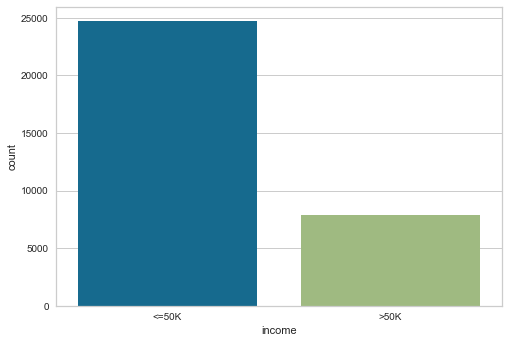

In [53]:
sns.countplot(x = censu['income']);

### Visão de age de acordo com cada workclass

O tamanho do bloco mostra a representatividade

In [54]:
grafico = px.treemap(censu, path=['workclass', 'age'])
grafico.show()
del(grafico)

## 3 - Preparação dos dados

Separa os dados nas variáveis em:

 - `preditoras (x)`: utilizadas para ensinar o modelo
 - `resposta (y)`: valor que desejamos encontrar

In [55]:
# utilizaremos todas as variáveis da base, com excessão de: income (variável y) e educatuon-num
x_censu = censu[censu.columns[~censu.columns.isin(['index', 'income', 'education-num'])]]
y_censu = censu.income

Para cada coluna categórica será criada uma coluna semelhante com classificação numérica para que possa ser utilizada em modelos que não permitam o uso de dados assim. Este processo é chamado de `Label encoding`

In [56]:
from sklearn.preprocessing import LabelEncoder

for column in x_censu:
    if x_censu[column].dtype == object:
        #print(column + '_encoded')
        label_encoder = LabelEncoder()
        x_censu[str(column) + '_encoded'] = label_encoder.fit_transform(x_censu[column])


del(label_encoder)
del(column)

Separação dos dados em `teste` (75%) e `treino` (25%)

In [57]:
from sklearn.model_selection import train_test_split

x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = train_test_split(x_censu, y_censu, test_size = 0.25, random_state = 0)

Os dados serão salvos no arquivo `censu.pkl` para que possam ser utilizado nos modelos sem a necessidade de novo carregamento e transformação

In [58]:
import pickle

with open('censu.pkl', mode = 'wb') as f:
  pickle.dump([x_censu, y_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste], f)

del(f)

## 4 - Naive Bayes

### 4.1 - Label encoding

Carregamento dos dados de treino e teste

In [59]:
import pickle
with open('censu.pkl', 'rb') as f:
  x_censu, y_censu,x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste = pickle.load(f)

del(f)

Para o método Naive Bayes serão utilizados apenas os dados numéricos, neste caso serão mantidas as colunas categóricas que foram convertidas

In [60]:
# apenas colunas serão utilizadas
names = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_encoded', 'education_encoded', 'marital-status_encoded', 'occupation_encoded', 'relationship_encoded', 'race_encoded', 'sex_encoded', 'native-country_encoded']

x_censu_treino = x_censu_treino[names]
x_censu_teste = x_censu_teste[names]

del(names)

O método Naive Bayes tende a apresentar melhores resultados quando os dados são estão padronizados, ou seja, que seus valores sejam todos colocados em uma escala, ja que temos valores com amplitude diferentes em cada coluna

In [61]:
#método z-score para padronizar as variveis explicativas
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#a padronização dos dados é feita apenas com as colunas numéricas
x_censu_treino = scaler.fit_transform(x_censu_treino)

del(scaler)

Criação e execução do modelo

In [62]:
from sklearn.naive_bayes import GaussianNB

naive_censu = GaussianNB()
naive_censu.fit(x_censu_treino, y_censu_treino)
previsoes = naive_censu.predict(x_censu_teste)

control_scores('Naive Bayes - label encoding', accuracy_score(y_censu_teste, previsoes))

Matriz de confusão

0.7892150841419973

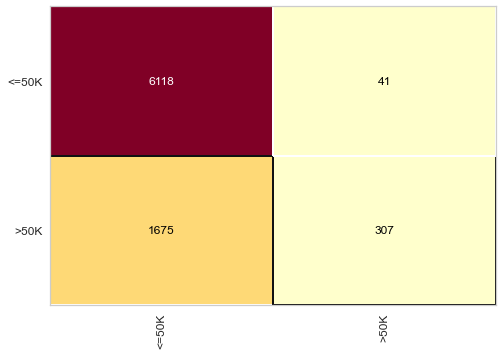

In [63]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(naive_censu)
cm.fit(x_censu_treino, y_censu_treino)
cm.score(x_censu_teste, y_censu_teste)

#del(cm)

### 4.2 - Utilização de variáveis dummies

Outra forma de trabalhar com dados categóricos é a utilização de variáveis dummies, onde ao invés de um campo numérico com o identificador de cada categoria são criadas colunas com valores binários (0 e 1) para cada categoria de cada variável.

In [64]:
import pickle
with open('censu.pkl', 'rb') as f:
  x_censu, y_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste = pickle.load(f)

del(f)

Ao invés de partirmos para a utilizarmos as variáveis categóricas convertidas em valores numéricos (variáveis com sufixo _encoded) vamos primeiro verificar quais caregorias possuem mais valores únicos. Para isso utilizaremos inicialmente a base **x_censu** com as variáveis preditoras sem a quebra de teste e treino

As variáveis `education`, `occupation` e `native-country` são as que possuem maiores categorias e podem ser transformadas de forma diferente.

In [65]:
x_censu.select_dtypes(include = 'object').describe()


,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22696,10501,14976,4140,13193,27816,21790,29170


Criaremos uma nova base com as variáveis 

In [66]:
x_censu_dummy = pd.get_dummies(
    x_censu, 
    #qual será o prefixo das colunas, manteremos o nome original
    prefix=['workclass', 'occupation', 'native-country'],
    #quais colunas serão avaliadas
    columns = ['workclass', 'occupation', 'native-country'],  
    #indicamos que desejamos que primeiro valor seja removido, uma vez que estamos trabalhando com variáveis binárias
    #podemos remover um dos valores categóricos para reduzir a quantidade de colunas, a presença dele pode ser detectada
    #ao verificar se as colunas remanecentes possuem valor 0
    drop_first = False)

Com a nova base criada (x_censu_dummy) é feita a remoção das colunas categóricas e das colunas convertidas (com sulfixo _encoded) que foram tranformadas em variáveis dummies

In [67]:
x_censu_dummy = x_censu_dummy[x_censu_dummy.columns[~x_censu_dummy.columns.isin([
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 
    'workclass_encoded', 'occupation_encoded', 'native-country_encoded'
])]]

from sklearn.model_selection import train_test_split

x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = train_test_split(x_censu_dummy, y_censu, test_size = 0.25, random_state = 0)

O método Naive Bayes tende a apresentar melhores resultados quando os dados são estão padronizados, ou seja, que seus valores sejam todos colocados em uma escala, ja que temos valores com amplitude diferentes em cada coluna

In [68]:
#método z-score para padronizar as variveis explicativas
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#a padronização dos dados é feita apenas com as colunas numéricas
x_censu_treino = scaler.fit_transform(x_censu_treino)

del(scaler)

**Criação e execução do modelo**

In [69]:
from sklearn.naive_bayes import GaussianNB

naive_censu_dummy = GaussianNB()
naive_censu_dummy.fit(x_censu_treino, y_censu_treino)
previsoes = naive_censu_dummy.predict(x_censu_teste)

control_scores('Naive Bayes - variaveis dummies', accuracy_score(y_censu_teste, previsoes))


**Matriz de confusão**

Podemos observar que não houve mudança na acuracidade do modelo

0.7892150841419973

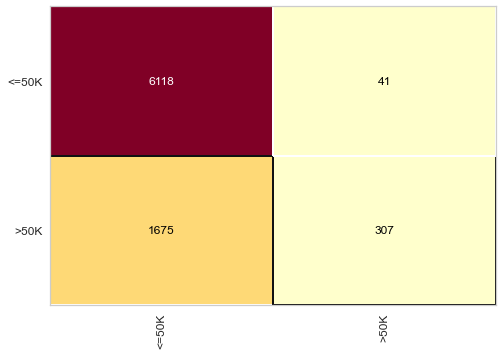

In [70]:
from yellowbrick.classifier import ConfusionMatrix
cm_dummy = ConfusionMatrix(naive_censu_dummy)
cm_dummy.fit(x_censu_treino, y_censu_treino)
cm_dummy.score(x_censu_teste, y_censu_teste)


## 5 - Árvore de decisão

O que são...

A primeira coisa a ser feita é a importação das variáveis de teste e treino

In [71]:
import pickle
with open('censu.pkl', 'rb') as f:
  x_censu, y_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste = pickle.load(f)

del(f)

Como os dados foram tratados e preparados anteriormente podemos partir direto para a criação do modelo

In [72]:
names = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
x_censu = x_censu[names]

del(names)

x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = train_test_split(x_censu_dummy, y_censu, test_size = 0.25, random_state = 0)

Criação e execução do modelo

In [73]:
from sklearn.tree import DecisionTreeClassifier

arvore_census = DecisionTreeClassifier(criterion='entropy', random_state=0)
arvore_census.fit(x_censu_treino, y_censu_treino)

previsoes = arvore_census.predict(x_censu_teste)

control_scores('Árvore de decisão', accuracy_score(y_censu_teste, previsoes))


0.815501781107972

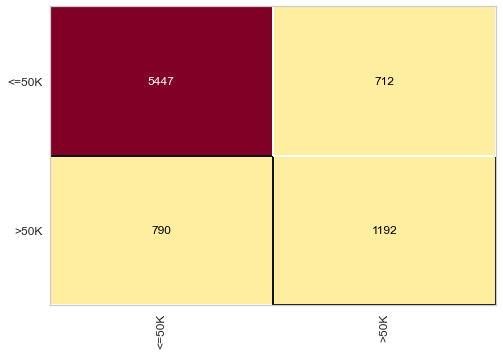

In [74]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(arvore_census)
cm.fit(x_censu_treino, y_censu_treino)
cm.score(x_censu_teste, y_censu_teste)

## 6 - Randon Forests


#### 6.1 - Variáveis categóricas

In [102]:
import pickle
with open('censu.pkl', 'rb') as f:
  x_censu, y_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste = pickle.load(f)

del(f)

In [103]:
names = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
x_censu = x_censu[names]

del(names)

x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = train_test_split(x_censu_dummy, y_censu, test_size = 0.25, random_state = 0)

In [104]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0)
random_forest.fit(x_censu_treino, y_censu_treino)
previsoes = random_forest.predict(x_censu_teste)

control_scores('Randon Forests - Variáveis Categóricas', accuracy_score(y_censu_teste, previsoes))

0.8505097653850878

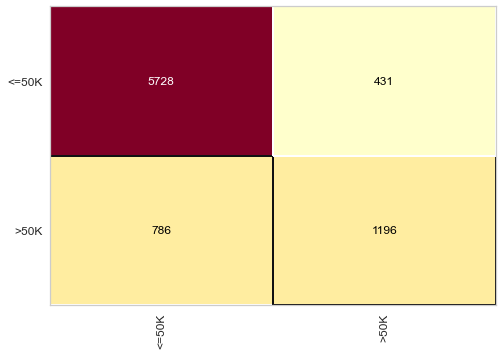

In [105]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(random_forest)
cm.fit(x_censu_treino, y_censu_treino)
cm.score(x_censu_teste, y_censu_teste)

#### 6.2 - Variáveis Dummies

In [106]:
import pickle
with open('censu.pkl', 'rb') as f:
  x_censu, y_censu, x_censu_treino, y_censu_treino, x_censu_teste, y_censu_teste = pickle.load(f)

del(f)

In [107]:
x_censu_dummy = pd.get_dummies(
    x_censu, 
    #qual será o prefixo das colunas, manteremos o nome original
    prefix=['workclass', 'occupation', 'native-country'],
    #quais colunas serão avaliadas
    columns = ['workclass', 'occupation', 'native-country'],  
    #indicamos que desejamos que primeiro valor seja removido, uma vez que estamos trabalhando com variáveis binárias
    #podemos remover um dos valores categóricos para reduzir a quantidade de colunas, a presença dele pode ser detectada
    #ao verificar se as colunas remanecentes possuem valor 0
    drop_first = False)

In [108]:
x_censu_dummy = x_censu_dummy[x_censu_dummy.columns[~x_censu_dummy.columns.isin([
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 
    'workclass_encoded', 'occupation_encoded', 'native-country_encoded'
])]]

from sklearn.model_selection import train_test_split

x_censu_treino, x_censu_teste, y_censu_treino, y_censu_teste = train_test_split(x_censu_dummy, y_censu, test_size = 0.25, random_state = 0)

In [111]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state = 0, verbose=1)
random_forest.fit(x_censu_treino, y_censu_treino)
previsoes = random_forest.predict(x_censu_teste)

control_scores('Randon Forests - Variáveis Categóricas', accuracy_score(y_censu_teste, previsoes))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


0.8512467755803955

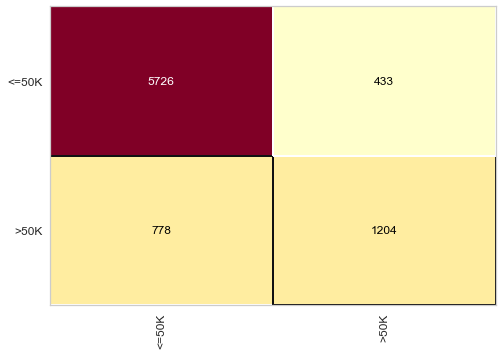

In [110]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(random_forest)
cm.fit(x_censu_treino, y_censu_treino)
cm.score(x_censu_teste, y_censu_teste)